# **CSE552 Homework 1**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

* [github.com/Berkin99/MachineLearning](https://github.com/Berkin99/MachineLearning)

Description: Experiments with KNN, SVM and DT in a :

- Classification 
(Audit - https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) and 

- Regression: 
(BikeSharing – https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) problems.

This assignment expects you to write five different functions to test your solutions to the given two
problems. You are to use the Python language. You will prepare a Jupyter Notebook (e.g., GoogleColab) 
including your code and results.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, roc_curve, auc
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
import time
import os
import time
import matplotlib.pyplot as plt

#### **Import Wisconsin Diagnostic Breast Cancer dataset**

In [2]:
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
audit_data = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), "../dataset/wdbc.data")), header=None, names=columns)
audit_data.drop(columns=["ID"], inplace=True)  # Remove ID column as it is not useful
audit_data["Diagnosis"] = audit_data["Diagnosis"].map({"M": 1, "B": 0})  # Convert M = 1 (Malignant), B = 0 (Benign)

#### **Import Daily and Hourly Bike Sharing dataset**

In [3]:
def bs_regularize(bs_data):
    # Drop unnecessary columns: "instant", "casual", "registered"
    bs_data.drop(columns=["instant", "casual", "registered"], inplace=True)

    # Extract day information from "dteday"
    bs_data["day"] = pd.to_datetime(bs_data["dteday"]).dt.day
    bs_data.drop(columns=["dteday"], inplace=True)

    # One-Hot Encoding for categorical variables
    bs_data = pd.get_dummies(bs_data, columns=["season", "weekday", "weathersit", "mnth"])

    # Convert all columns to numeric, and handle errors by coercing invalid entries
    bs_data = bs_data.apply(pd.to_numeric, errors="coerce")

    # Drop rows with missing values
    bs_data.dropna(inplace=True)
    return bs_data

bs_day = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), "../dataset/day.csv")))
bs_hour = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), "../dataset/hour.csv")))
bs_day = bs_regularize(bs_day)
bs_hour = bs_regularize(bs_hour)



In [4]:
#Data Stores for Performance
p_cs  = [] 
p_reg = []

## **Part 1: Build a classifier based on KNN (K=3 for testing) using Euclidean distance.**

* You are expected to code the KNN classifier (including the distance function).
* Report performance using an appropriate k-fold cross validation using confusion
matrices on the given dataset.
* Report the run time performance of your above tests.

In [6]:
# Compute Euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

# KNN classifier
def knn_classify(train_X, train_y, test_X, k=3):
    predictions = []
    for test_point in test_X:
        distances = euclidean_distance(train_X, test_point)  # Compute distances to all training points
        k_indices = np.argsort(distances)[:k]  # Get indices of K nearest neighbors
        k_labels = train_y[k_indices]  # Retrieve labels of these neighbors
        prediction = np.bincount(k_labels).argmax()  # Choose the most frequent label
        predictions.append(prediction)
    return np.array(predictions)

# Evaluate KNN using 6-fold cross-validation
def evaluate_knn(data, k=3):
    X = data.iloc[:, 1:].values  # Extract features
    y = data.iloc[:, 0].values  # Extract labels
    kf = KFold(n_splits=6, shuffle=True, random_state=40)  # 6-fold cross-validation
    
    total_cm = np.zeros((2, 2), dtype=int)
    accuracies = []
    start_time = time.time()
    
    # Loop through each fold
    fold_count = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Perform classification and evaluate performance
        y_pred = knn_classify(X_train, y_train, X_test, k)
        
        # Calculate confusion matrix and accuracy
        cm = confusion_matrix(y_test, y_pred)
        total_cm += cm
        fold_accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(fold_accuracy)
        
        # Print the results for this fold
        print(f"\nFold {fold_count} Accuracy: {fold_accuracy:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        
        fold_count += 1
    
    end_time = time.time()
    avg_accuracy = np.mean(accuracies)
    runtime = end_time - start_time
    
    # Print overall performance
    print("\nOverall Performance (after 6 folds):")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Total Runtime: {runtime:.4f} seconds")
    print(f"Total Confusion Matrix:\n{total_cm}")

    return avg_accuracy, runtime

acc, rt = evaluate_knn(k=3,data=audit_data)
p_cs.append(["KNN-3", acc, rt])



Fold 1 Accuracy: 0.9368
Confusion Matrix:
[[58  2]
 [ 4 31]]

Fold 2 Accuracy: 0.9474
Confusion Matrix:
[[68  1]
 [ 4 22]]

Fold 3 Accuracy: 0.9158
Confusion Matrix:
[[52  5]
 [ 3 35]]

Fold 4 Accuracy: 0.8842
Confusion Matrix:
[[55  4]
 [ 7 29]]

Fold 5 Accuracy: 0.9579
Confusion Matrix:
[[55  3]
 [ 1 36]]

Fold 6 Accuracy: 0.9362
Confusion Matrix:
[[54  0]
 [ 6 34]]

Overall Performance (after 6 folds):
Average Accuracy: 0.9297
Total Runtime: 0.0409 seconds
Total Confusion Matrix:
[[342  15]
 [ 25 187]]


## **Part 2: Build a regressor based on KNN (K=3 for testing) using Manhattan distance.**

* You are expected to code the KNN classifier (including the distance function).
* Report performance using an appropriate k-fold cross validation on the given dataset.
* Report the run time performance of your above tests

In [8]:
# Compute Manhattan distance
def manhattan_distance(x1, x2):
    # Compute Manhattan distance between two points
    return np.sum(np.abs(x1 - x2), axis=1)

# KNN Regressor (using Manhattan distance)
def knn_regressor(train_X, train_y, test_X, k=3):
    predictions = []
    for test_point in test_X:
        # Calculate distances from test point to all training points
        distances = manhattan_distance(train_X, test_point)
        
        # Get indices of k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        
        # Get the target values (y) for those k nearest neighbors
        k_values = train_y[k_indices]
        
        # Predict the average of k nearest neighbors (regression)
        predictions.append(np.mean(k_values)) 
    
    return np.array(predictions)

# Evaluate KNN regressor using k-fold cross-validation
def evaluate_knn(data, target_column, k=3, folds=5):
    # Split data into features and target variable
    X = data.drop(columns=[target_column]).values
    y = data[target_column].values

    # Initialize KFold cross-validation with specified splits
    kf = KFold(n_splits=folds, shuffle=True, random_state=40)

    total_train_mae = []  # To store training Mean Absolute Error for each fold
    total_test_mae = []  # To store testing Mean Absolute Error for each fold
    start_time = time.time()  # Record start time for performance measurement

    # Loop through each fold
    fold_count = 1
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Make predictions using the KNN regressor for training and test sets
        y_train_pred = knn_regressor(X_train, y_train, X_train, k)
        y_test_pred = knn_regressor(X_train, y_train, X_test, k)
        
        # Calculate Mean Absolute Error for both training and testing data
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        total_train_mae.append(train_mae)
        total_test_mae.append(test_mae)

        # Print the results for this fold
        print(f"Fold {fold_count} Performance:")
        print(f"Training MAE: {train_mae:.4f}")
        print(f"Testing MAE: {test_mae:.4f}")
        
        fold_count += 1

    end_time = time.time()  # Record end time
    avg_train_mae = np.mean(total_train_mae)  # Average training MAE across all folds
    avg_test_mae = np.mean(total_test_mae)  # Average testing MAE across all folds
    runtime = end_time - start_time  # Total runtime for cross-validation

    # Print overall performance
    print(f"\nOverall Performance (after {folds} folds):")
    print(f"Average Training MAE: {avg_train_mae:.4f}")
    print(f"Average Testing MAE: {avg_test_mae:.4f}")
    print(f"Total Runtime: {runtime:.4f} seconds")

    return avg_test_mae, runtime

target = "cnt"  # The target column to predict
mae, rt = evaluate_knn(bs_day, target, k=3, folds=6)
p_reg.append(["KNN-3", mae, rt])


Fold 1 Performance:
Training MAE: 770.5090
Testing MAE: 1049.1284
Fold 2 Performance:
Training MAE: 784.0536
Testing MAE: 1214.3497
Fold 3 Performance:
Training MAE: 780.7603
Testing MAE: 1121.9180
Fold 4 Performance:
Training MAE: 770.4915
Testing MAE: 1161.0437
Fold 5 Performance:
Training MAE: 780.7849
Testing MAE: 1171.3552
Fold 6 Performance:
Training MAE: 784.6645
Testing MAE: 1054.9339

Overall Performance (after 6 folds):
Average Training MAE: 778.5440
Average Testing MAE: 1128.7882
Total Runtime: 4.0589 seconds


## **Part 3: Model a classifier based on the linear SVM.**
* You may use any available implementation of SVM in Python.
* Report performance using an appropriate k-fold cross validation using ROC curves and
confusion matrices. Find the best threshold for the SVM output as described in the
note by Fawcett.
* Report the run time performance of your above tests

Fold 1 Performance:
Confusion Matrix:
[[56  4]
 [ 2 33]]
Accuracy: 0.9368
ROC AUC: 0.9938
Fold 2 Performance:
Confusion Matrix:
[[67  2]
 [ 1 25]]
Accuracy: 0.9684
ROC AUC: 0.9955
Fold 3 Performance:
Confusion Matrix:
[[57  0]
 [ 3 35]]
Accuracy: 0.9684
ROC AUC: 0.9986
Fold 4 Performance:
Confusion Matrix:
[[56  3]
 [ 5 31]]
Accuracy: 0.9158
ROC AUC: 0.9783
Fold 5 Performance:
Confusion Matrix:
[[57  1]
 [ 0 37]]
Accuracy: 0.9895
ROC AUC: 0.9995
Fold 6 Performance:
Confusion Matrix:
[[53  1]
 [ 5 35]]
Accuracy: 0.9362
ROC AUC: 0.9824


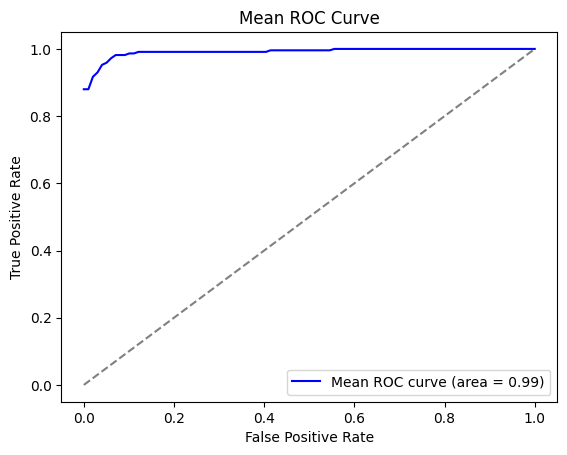


Overall Performance (after 6 folds):
Average Accuracy: 0.9525
Average ROC AUC: 0.9914
Total Runtime: 26.7905 seconds


In [9]:
# Function to train the SVM model
def train_svm(X_train, y_train):
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    return model

# Function to make predictions with the SVM model
def make_predictions(model, X_test):
    return model.predict(X_test), model.predict_proba(X_test)[:, 1]

# Function to calculate metrics: Confusion Matrix, Accuracy, and ROC AUC
def evaluate_metrics(y_test, y_pred, y_prob):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return cm, accuracy, fpr, tpr, roc_auc

# Function to print fold performance
def print_fold_performance(fold_count, cm, accuracy, roc_auc):
    print(f"Fold {fold_count} Performance:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

# Function to calculate average TPR and FPR for the ROC curve
def calculate_mean_roc(tpr_list, fpr_list):
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_fpr = np.mean(fpr_list, axis=0)
    return mean_fpr, mean_tpr

# Main evaluation function for SVM using k-fold cross-validation
def evaluate_svm(data, folds=6):
    X = data.iloc[:, 1:].values  # Extract features
    y = data.iloc[:, 0].values  # Extract labels
    kf = KFold(n_splits=folds, shuffle=True, random_state=40)
    
    accuracies = []
    tpr_list = []
    fpr_list = []
    roc_auc_list = []
    start_time = time.time()
    
    fold_count = 1
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the SVM model
        model = train_svm(X_train, y_train)
        
        # Make predictions
        y_pred, y_prob = make_predictions(model, X_test)
        
        # Calculate metrics
        cm, accuracy, fpr, tpr, roc_auc = evaluate_metrics(y_test, y_pred, y_prob)
        
        # Store values for reporting
        accuracies.append(accuracy)
        tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))  # Interpolate TPR values
        fpr_list.append(np.linspace(0, 1, 100))  # Interpolate FPR values to be consistent
        roc_auc_list.append(roc_auc)
        
        # Print performance for the current fold
        print_fold_performance(fold_count, cm, accuracy, roc_auc)
        
        fold_count += 1
    
    end_time = time.time()
    avg_accuracy = np.mean(accuracies)
    avg_roc_auc = np.mean(roc_auc_list)
    runtime = end_time - start_time
    
    # Calculate average TPR and FPR for plotting the ROC curve
    mean_fpr, mean_tpr = calculate_mean_roc(tpr_list, fpr_list)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {avg_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return avg_accuracy, avg_roc_auc, runtime

# Example usage
# Assuming 'audit_data' is your dataset
# Evaluate the SVM and report results for a 6-fold cross-validation
acc, roc_auc, rt = evaluate_svm(audit_data, folds=6)

# Print overall performance after all folds
print(f"\nOverall Performance (after 6 folds):")
print(f"Average Accuracy: {acc:.4f}")
print(f"Average ROC AUC: {roc_auc:.4f}")
print(f"Total Runtime: {rt:.4f} seconds")

p_cs.append(["SVM", acc, rt])

## **Part 4: Model a regressor based on the linear SVM.**
* You may use an available implementation of SVM in Python.
* Report performance using an appropriate k-fold cross validation.
* Report the run time performance of your above tests.

In [10]:

# Linear SVM Regressor
def svm_regressor(train_X, train_y, test_X):
    # Initialize the Support Vector Regressor with a linear kernel
    svr = SVR(kernel='linear')
    
    # Train the model on the training data
    svr.fit(train_X, train_y)
    
    # Make predictions on the test data
    predictions = svr.predict(test_X)
    
    return predictions, svr

# Evaluate SVM Regressor using k-fold cross-validation
def evaluate_svm(data, target_column, folds=6):
    # Split data into features and target variable
    X = data.drop(columns=[target_column]).values
    y = data[target_column].values

    # Initialize KFold cross-validation with 6 splits
    kf = KFold(n_splits=folds, shuffle=True, random_state=40)

    total_mae = []  # To store Mean Absolute Error for each fold
    start_time = time.time()  # Record start time for performance measurement

    fold_count = 1
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Make predictions using the SVM regressor
        y_pred, model = svm_regressor(X_train, y_train, X_test)
        
        # Calculate Mean Absolute Error for both training and testing sets
        train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        
        # Append the test MAE for the fold
        total_mae.append(test_mae)

        # Print performance for the current fold
        print(f"\nFold {fold_count} Performance:")
        print(f"Training MAE: {train_mae:.4f}")
        print(f"Testing MAE: {test_mae:.4f}")
        
        fold_count += 1

    end_time = time.time()  # Record end time
    avg_mae = np.mean(total_mae)  # Average MAE across all folds
    runtime = end_time - start_time  # Total runtime for cross-validation

    return avg_mae, runtime


target = "cnt"  # The target column to predict

# Evaluate the SVM regressor and report results for the 6-fold cross-validation
mae, rt = evaluate_svm(bs_day, target, folds=6)
# Print overall results: Average MAE and Total Runtime
print(f"\nOverall Performance (after 6 folds):")
print(f"Average Testing MAE: {mae:.4f}")
print(f"Total Runtime: {rt:.4f} seconds")

p_reg.append(["SVM", mae, rt])



Fold 1 Performance:
Training MAE: 1499.6248
Testing MAE: 1366.8559

Fold 2 Performance:
Training MAE: 1483.4391
Testing MAE: 1436.7099

Fold 3 Performance:
Training MAE: 1482.3043
Testing MAE: 1445.4390

Fold 4 Performance:
Training MAE: 1446.0458
Testing MAE: 1651.1965

Fold 5 Performance:
Training MAE: 1461.9226
Testing MAE: 1532.9615

Fold 6 Performance:
Training MAE: 1480.1577
Testing MAE: 1450.9178

Overall Performance (after 6 folds):
Average Testing MAE: 1480.6801
Total Runtime: 0.1407 seconds


## **Part 5: Model a classifier based on DT (Decision Trees).**
* You may use any available implementation of DTs in Python.
* Experiment with two different pruning strategies (explain what you use).
* Report performance using an appropriate k-fold cross validation.
* Write a function to convert one of your decision trees into a set of rules (i.e., extract the path to each leaf nodes).


Fold 1 Performance:
Confusion Matrix:
[[57  3]
 [ 1 34]]
Accuracy: 0.9579
ROC AUC: 0.9743
Fold 2 Performance:
Confusion Matrix:
[[65  4]
 [ 4 22]]
Accuracy: 0.9158
ROC AUC: 0.9685
Fold 3 Performance:
Confusion Matrix:
[[57  0]
 [ 5 33]]
Accuracy: 0.9474
ROC AUC: 0.9836
Fold 4 Performance:
Confusion Matrix:
[[55  4]
 [ 7 29]]
Accuracy: 0.8842
ROC AUC: 0.9350
Fold 5 Performance:
Confusion Matrix:
[[55  3]
 [ 1 36]]
Accuracy: 0.9579
ROC AUC: 0.9469
Fold 6 Performance:
Confusion Matrix:
[[53  1]
 [ 2 38]]
Accuracy: 0.9681
ROC AUC: 0.9657


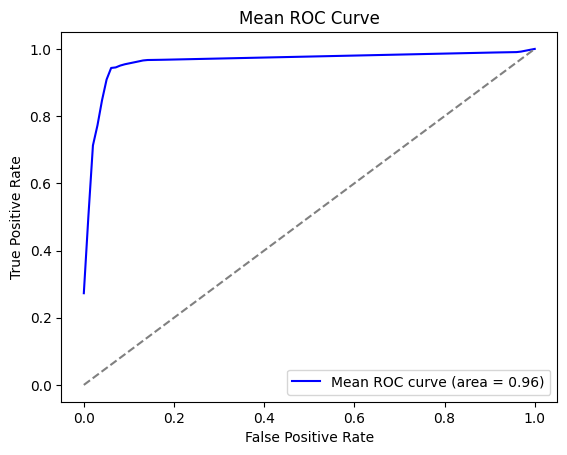


Overall Performance (after 6 folds):
Average Accuracy: 0.9385
Average ROC AUC: 0.9623
Total Runtime: 0.0635 seconds


In [11]:
# Function to train the Decision Tree model with pruning strategies
def train_decision_tree(X_train, y_train, max_depth=None, min_samples_leaf=1):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to make predictions with the Decision Tree model
def make_predictions(model, X_test):
    return model.predict(X_test), model.predict_proba(X_test)[:, 1]

# Function to calculate metrics: Confusion Matrix, Accuracy, and ROC AUC
def evaluate_metrics(y_test, y_pred, y_prob):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return cm, accuracy, fpr, tpr, roc_auc

# Function to print fold performance
def print_fold_performance(fold_count, cm, accuracy, roc_auc):
    print(f"Fold {fold_count} Performance:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

# Function to calculate average TPR and FPR for the ROC curve
def calculate_mean_roc(tpr_list, fpr_list):
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_fpr = np.mean(fpr_list, axis=0)
    return mean_fpr, mean_tpr

# Main evaluation function for Decision Tree using k-fold cross-validation
def evaluate_decision_tree(data, folds=6, max_depth=None, min_samples_leaf=1):
    X = data.iloc[:, 1:].values  # Extract features
    y = data.iloc[:, 0].values  # Extract labels
    kf = KFold(n_splits=folds, shuffle=True, random_state=40)
    
    accuracies = []
    tpr_list = []
    fpr_list = []
    roc_auc_list = []
    start_time = time.time()
    
    fold_count = 1
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the Decision Tree model
        model = train_decision_tree(X_train, y_train, max_depth, min_samples_leaf)
        
        # Make predictions
        y_pred, y_prob = make_predictions(model, X_test)
        
        # Calculate metrics
        cm, accuracy, fpr, tpr, roc_auc = evaluate_metrics(y_test, y_pred, y_prob)
        
        # Store values for reporting
        accuracies.append(accuracy)
        tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))  # Interpolate TPR values
        fpr_list.append(np.linspace(0, 1, 100))  # Interpolate FPR values to be consistent
        roc_auc_list.append(roc_auc)
        
        # Print performance for the current fold
        print_fold_performance(fold_count, cm, accuracy, roc_auc)
        
        fold_count += 1
    
    end_time = time.time()
    avg_accuracy = np.mean(accuracies)
    avg_roc_auc = np.mean(roc_auc_list)
    runtime = end_time - start_time
    
    # Calculate average TPR and FPR for plotting the ROC curve
    mean_fpr, mean_tpr = calculate_mean_roc(tpr_list, fpr_list)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (area = {avg_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return avg_accuracy, avg_roc_auc, runtime

# Function to extract rules from the Decision Tree
def extract_rules(model, feature_names):
    tree_rules = export_text(model, feature_names=feature_names)
    return tree_rules


max_depth = 5  # Experiment with a pruning strategy by limiting tree depth
min_samples_leaf = 5  # Experiment with a pruning strategy by setting minimum samples per leaf

acc, roc_auc, rt = evaluate_decision_tree(audit_data, folds=6, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

# Print overall performance after all folds
print(f"\nOverall Performance (after 6 folds):")
print(f"Average Accuracy: {acc:.4f}")
print(f"Average ROC AUC: {roc_auc:.4f}")
print(f"Total Runtime: {rt:.4f} seconds")

# Extract and print rules for the last fold's trained model
final_model = train_decision_tree(audit_data.iloc[:, 1:], audit_data.iloc[:, 0], max_depth=max_depth, min_samples_leaf=min_samples_leaf)
rules = extract_rules(final_model, audit_data.columns[1:])

p_cs.append(["DT", acc, rt])

In [81]:

print("\nDecision Tree Rules:\n", rules)


Decision Tree Rules:
 |--- feature_21 <= 16.80
|   |--- feature_28 <= 0.14
|   |   |--- feature_14 <= 48.98
|   |   |   |--- feature_24 <= 785.75
|   |   |   |   |--- feature_22 <= 33.35
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_22 >  33.35
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_24 >  785.75
|   |   |   |   |--- feature_22 <= 29.18
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_22 >  29.18
|   |   |   |   |   |--- class: 0
|   |   |--- feature_14 >  48.98
|   |   |   |--- class: 0
|   |--- feature_28 >  0.14
|   |   |--- feature_22 <= 25.67
|   |   |   |--- feature_24 <= 805.90
|   |   |   |   |--- feature_1 <= 12.55
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  12.55
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_24 >  805.90
|   |   |   |   |--- class: 1
|   |   |--- feature_22 >  25.67
|   |   |   |--- feature_8 <= 0.05
|   |   |   |   |--- class: 0
|   |   |   |--- feature_8 >  0.05
|   |   

## **Part 6: Model a regressor based on DT (Decision Trees).**
* You may use an available implementation of DTs in Python.
* Report performance using an appropriate k-fold cross validation.
* Write a function to convert one of your decision trees into a set of rules (i.e., extract the path to each leaf nodes).

In [13]:
# Decision Tree Regressor
def decision_tree_regressor(train_X, train_y, test_X):
    # Initialize the Decision Tree Regressor
    regressor = DecisionTreeRegressor(random_state=42)
    
    # Train the model on the training data
    regressor.fit(train_X, train_y)
    
    # Make predictions on the test data
    predictions = regressor.predict(test_X)
    
    return predictions, regressor

# Evaluate Decision Tree Regressor using k-fold cross-validation
def evaluate_decision_tree(data, target_column, folds=6):
    # Split data into features and target variable
    X = data.drop(columns=[target_column]).values
    y = data[target_column].values

    # Initialize KFold cross-validation with 6 splits
    kf = KFold(n_splits=folds, shuffle=True, random_state=40)

    total_mae = []  # To store Mean Absolute Error for each fold
    start_time = time.time()  # Record start time for performance measurement

    fold_count = 1
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Make predictions using the Decision Tree regressor
        y_pred, model = decision_tree_regressor(X_train, y_train, X_test)
        
        # Calculate Mean Absolute Error for both training and testing sets
        train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        
        # Append the test MAE for the fold
        total_mae.append(test_mae)

        # Print performance for the current fold
        print(f"\nFold {fold_count} Performance:")
        print(f"Training MAE: {train_mae:.4f}")
        print(f"Testing MAE: {test_mae:.4f}")
        
        fold_count += 1

    end_time = time.time()  # Record end time
    avg_mae = np.mean(total_mae)  # Average MAE across all folds
    runtime = end_time - start_time  # Total runtime for cross-validation

    return avg_mae, runtime

# Function to extract rules from the Decision Tree
def extract_rules(model, feature_names):
    tree_rules = export_text(model, feature_names=feature_names)
    return tree_rules



### BS_DAY Data :

In [14]:
target = "cnt"  # The target column to predict

# Evaluate the Decision Tree regressor and report results for the 6-fold cross-validation
acc, rt = evaluate_decision_tree(bs_day, target, folds=6)

# Print overall results: Average MAE and Total Runtime
print(f"\nOverall Performance (after 6 folds):")
print(f"Average Testing MAE: {acc:.4f}")
print(f"Total Runtime: {rt:.4f} seconds")

# Extract and print rules for the last fold's trained model
final_model = decision_tree_regressor(bs_day.drop(columns=[target]), bs_day[target], bs_day.drop(columns=[target]))[1]
rules = extract_rules(final_model, bs_day.drop(columns=[target]).columns)

p_reg.append(["DT-BS_DAY", acc, rt])



Fold 1 Performance:
Training MAE: 0.0000
Testing MAE: 654.0328

Fold 2 Performance:
Training MAE: 0.0000
Testing MAE: 620.1230

Fold 3 Performance:
Training MAE: 0.0000
Testing MAE: 665.6230

Fold 4 Performance:
Training MAE: 0.0000
Testing MAE: 608.3443

Fold 5 Performance:
Training MAE: 0.0000
Testing MAE: 645.0082

Fold 6 Performance:
Training MAE: 0.0000
Testing MAE: 718.2066

Overall Performance (after 6 folds):
Average Testing MAE: 651.8896
Total Runtime: 0.0560 seconds


### BS_HOUR Data :

In [16]:
target = "cnt"  # The target column to predict

# Evaluate the Decision Tree regressor and report results for the 6-fold cross-validation
acc, rt = evaluate_decision_tree(bs_hour, target, folds=6)

# Print overall results: Average MAE and Total Runtime
print(f"\nOverall Performance (after 6 folds):")
print(f"Average Testing MAE: {acc:.4f}")
print(f"Total Runtime: {rt:.4f} seconds")

# Extract and print rules for the last fold's trained model
final_model = decision_tree_regressor(bs_hour.drop(columns=[target]), bs_hour[target], bs_hour.drop(columns=[target]))[1]
rules = extract_rules(final_model, bs_hour.drop(columns=[target]).columns)

p_reg.append(["DT-BS_HOUR", acc, rt])


Fold 1 Performance:
Training MAE: 0.0000
Testing MAE: 34.4239

Fold 2 Performance:
Training MAE: 0.0000
Testing MAE: 34.5043

Fold 3 Performance:
Training MAE: 0.0000
Testing MAE: 33.2119

Fold 4 Performance:
Training MAE: 0.0000
Testing MAE: 33.9347

Fold 5 Performance:
Training MAE: 0.0000
Testing MAE: 36.2438

Fold 6 Performance:
Training MAE: 0.0000
Testing MAE: 33.8008

Overall Performance (after 6 folds):
Average Testing MAE: 34.3532
Total Runtime: 0.9625 seconds


## **RESULTS**

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_performance_comparison(p_reg, y_name):
    # Extract the model names, accuracies, and runtimes from p_reg
    models = [entry[0] for entry in p_reg]
    accuracies = [entry[1] for entry in p_reg]
    runtimes = [entry[2] for entry in p_reg]
    
    # Define the width of the bars
    bar_width = 0.5
    index = np.arange(len(models))  # Create x positions for the bars

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Accuracy Bar Chart
    ax1.bar(index, accuracies, bar_width, color='b')
    ax1.set_xlabel('Models')
    ax1.set_ylabel(y_name)
    ax1.set_title('Accuracy Comparison for Different Models')
    ax1.set_xticks(index)
    ax1.set_xticklabels(models, rotation=45, ha="right")

    # Plot Runtime Bar Chart
    ax2.bar(index, runtimes, bar_width, color='g')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_title('Runtime Comparison for Different Models')
    ax2.set_xticks(index)
    ax2.set_xticklabels(models, rotation=45, ha="right")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


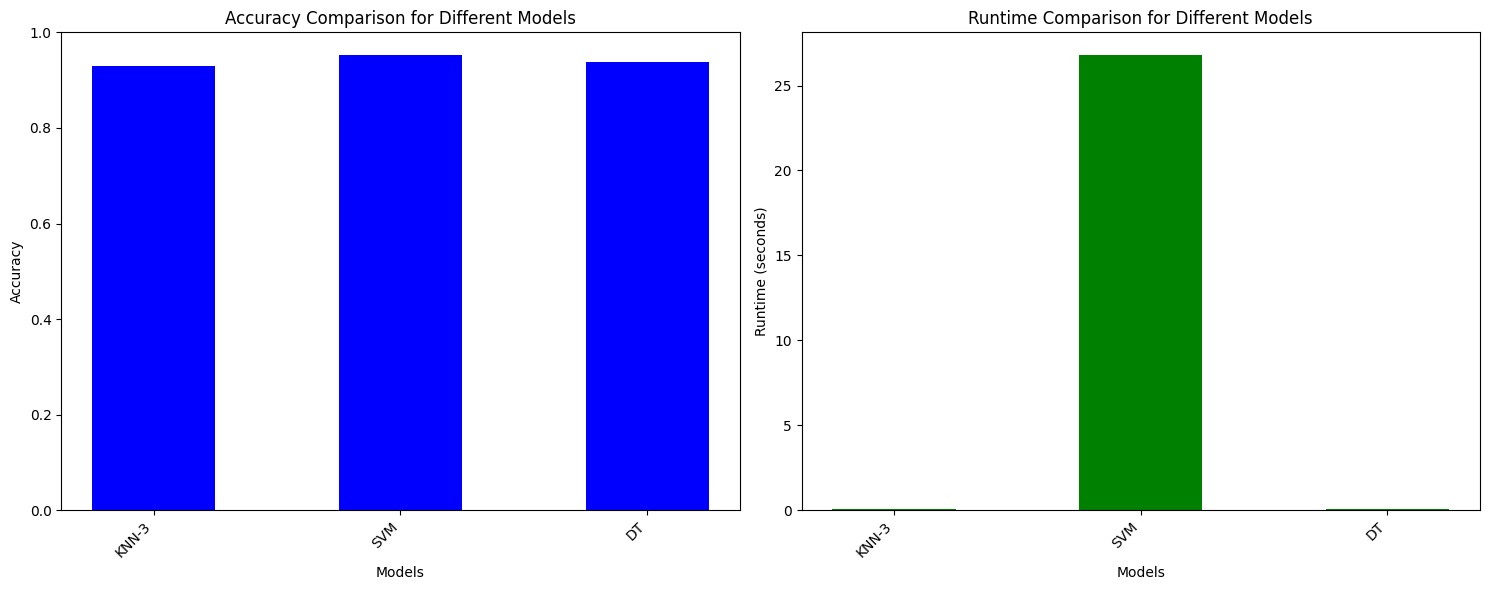

In [25]:
plot_performance_comparison(p_cs, "Accuracy")

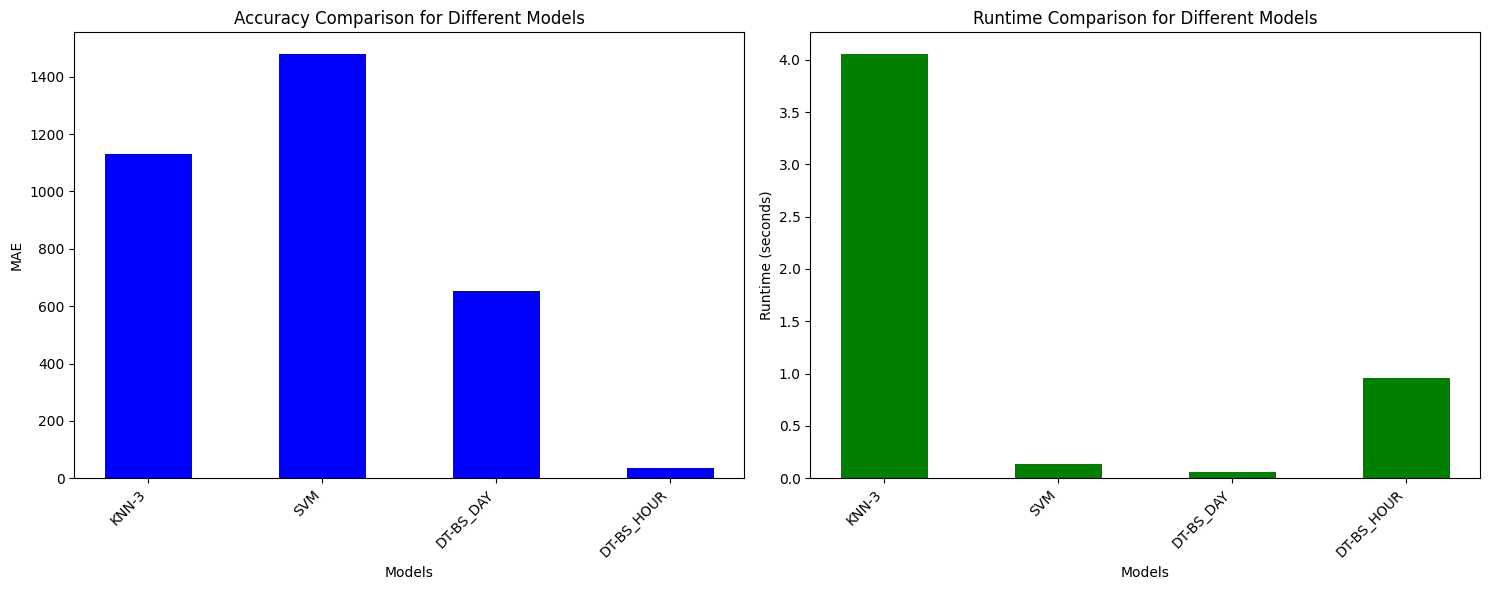

In [26]:
plot_performance_comparison(p_reg, "MAE")

## **CONCLUSION**

Decision Trees (DT) provide high accuracy and are fast to train, especially when the data is well-structured. They are easy to interpret, which makes them a popular choice for problems requiring model transparency. However, they can suffer from overfitting, especially with deep trees, which can be mitigated using pruning techniques.

K-Nearest Neighbors (KNN) works well with small datasets and those that have a good distribution of classes. It is simple to understand but becomes computationally expensive with large datasets, as the algorithm requires storing the entire dataset. Additionally, KNN's performance drops significantly with high-dimensional data due to the "curse of dimensionality."

Support Vector Machines (SVM) are effective for high-dimensional spaces, they can be quite slow, especially with large datasets and when using non-linear kernels. The training time can be significantly higher compared to DT or KNN, making them less practical in time-sensitive scenarios.